# Attenuation Analysis of Lead and Aluminum Against Gamma Ray Sources
**Goal**: To compute the attenuation constants for two different materials, Aluminum (Al) and Lead (Pb).  We setup a gamma ray source under the Na detector and progressively put more shielding of the material between the source and detector.  The ability of the material to absorb or *"shield"* the radiation can be quantified by its attenuation constant.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette='tab10')

In [3]:
xls = pd.ExcelFile('data/lead_data_2.xlsx')
df1 = pd.read_excel(xls, 'lead_v2')
df1.head()

,time,lead (mm),count
0,1,6.1725,442
1,2,6.1725,448
2,3,6.1725,429
3,4,6.1725,411
4,5,6.1725,441


Per Introduction to Error Analysis by Taylor, 2nd ed. for a counting experiment the uncertainty if you count $x$ values is $\sqrt{x}$.

In [4]:
df1.loc[:, 'unc_count'] = np.sqrt(df1['count'])
df1.head(5)

,time,lead (mm),count,unc_count
0,1,6.1725,442,21.023796
1,2,6.1725,448,21.166010
2,3,6.1725,429,20.712315
3,4,6.1725,411,20.273135
4,5,6.1725,441,21.000000


Per my lab notebook (p.28) the dwell time was set to 2 seconds for this experiment.  So to get the intensity in the right units of $\frac{count}{sec}$ I have to divide by 2.  And also divide the error in the count as well.  This is a simple function of halving it so based on:

$\delta f(y) = \left|\frac{d f(y)} {dy}\right| \delta y$

$f(y) = \frac{y}{2}$

In [5]:
df1.loc[:, 'count'] = df1.loc[:, 'count'] / 2
df1.loc[:, 'unc_count'] = df1.loc[:, 'unc_count'] / 2

Converting from mm to cm

In [6]:
df1['lead (mm)'] = df1['lead (mm)'] / 10.
df1 = df1.rename(columns={'lead (mm)': 'lead (cm)'})

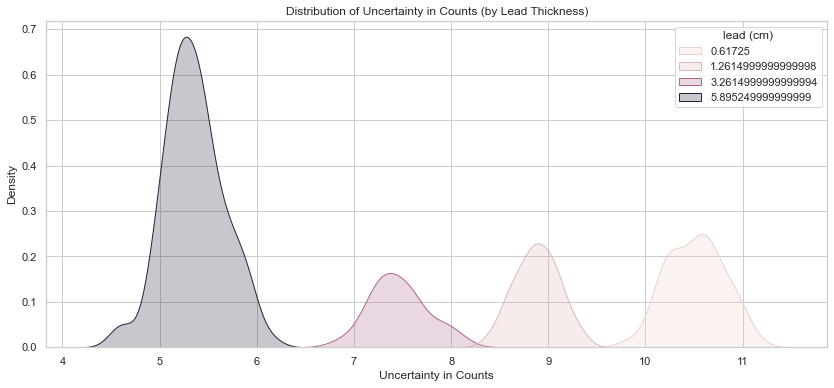

In [7]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=df1, x='unc_count', hue='lead (cm)', fill=True)
plt.xlabel('Uncertainty in Counts')
plt.title('Distribution of Uncertainty in Counts (by Lead Thickness)')
plt.show()

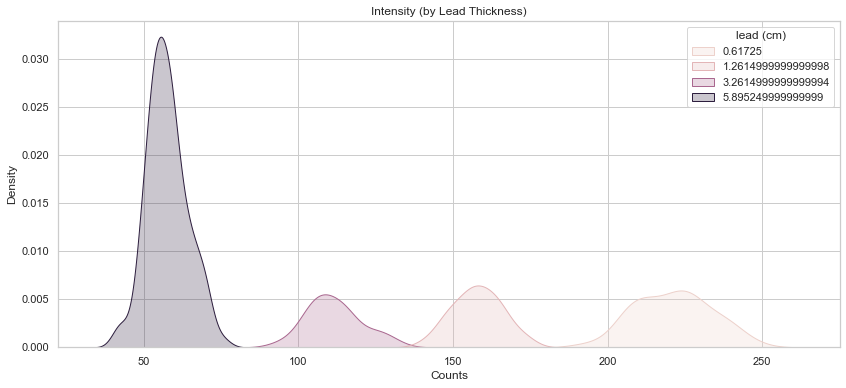

In [8]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=df1, x='count', hue='lead (cm)', fill=True)
plt.xlabel('Counts')
plt.title('Intensity (by Lead Thickness)')
plt.show()

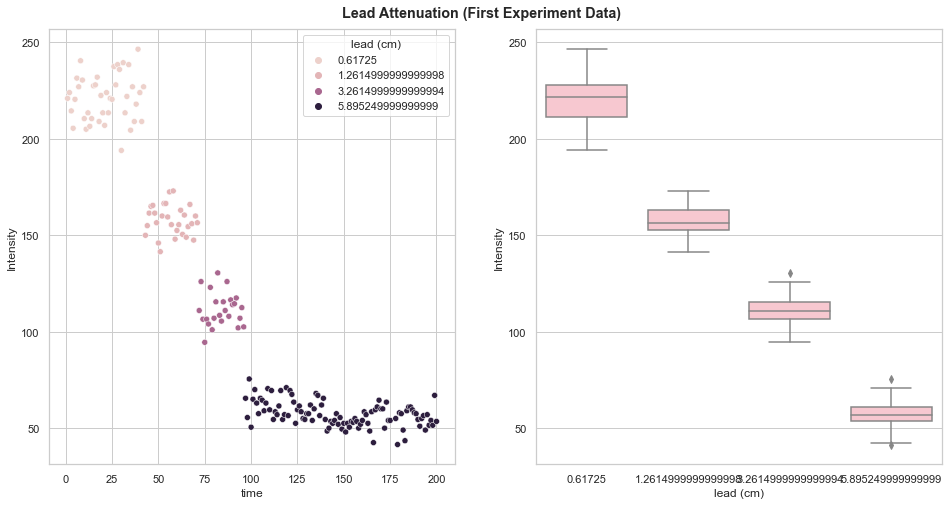

In [9]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

sns.scatterplot(ax=axes[0], data=df1, x='time', y='count', hue='lead (cm)')
axes[0].set_ylabel('Intensity')
sns.boxplot(ax=axes[1], data=df1, x='lead (cm)', y='count', color='pink')
plt.suptitle('Lead Attenuation (First Experiment Data)', y=0.92, fontweight='bold')
axes[1].set_ylabel('Intensity')
plt.show()

**Outliers:** These two graphs, but especially the boxplot on the right makes it clear there's a pair of outliers in the data.  In the 4.175 (3rd) lead group there's one that's pretty high, and on the 8.3 lead (next to last) there's one that's very low.  They're in the middle of the data roughly, so it's not like they belong to the neighboring groups.  In the end they don't seem to have much of an impact on the data so I'll ignore them for now.  If I have more time I might bother removing them and comparing the difference in results.

In [10]:
lead_1 = df1.loc[:, ['lead (cm)', 'count', 'unc_count']].groupby('lead (cm)').agg(['mean', 'std', 'count', 'median'])
# Flatten the multi-index that gets created
#lead_1.columns = lead_1.columns.get_level_values(1).astype(str)
lead_1

count                          unc_count                  \
                 mean        std count median       mean       std count   
lead (cm)                                                                  
0.61725    221.238095  12.009264    42  221.5  10.513773  0.285600    42   
1.26150    157.775862   7.823484    29  156.5   8.879247  0.220392    29   
3.26150    111.460000   8.655345    25  111.0   7.459911  0.288183    25   
5.89525     57.382353   6.470488   102   57.0   5.348027  0.301127   102   

                      
              median  
lead (cm)             
0.61725    10.523776  
1.26150     8.845903  
3.26150     7.449832  
5.89525     5.338539

## Errors & Uncertainty
I had some concern about what to do when averaging the intensity values here for each measurement of lead and in particular how to propagate the uncertainties.  Should I be using the standard deviation $\sigma$ of the intensity counts?  Or should I propagate through the uncertainty values I'd earlier computed?

It turns out it doesn't matter as the $\sigma \approx \delta y$.  So I could use either, I think I'll just use the $\sigma$ to calculate $\sigma_y = \frac{\sigma}{\sqrt{n}}$ as **y_err**.

In [11]:
# Dropping the unc_count values & resetting the columns
lead_1 = lead_1.drop(columns=['unc_count'])
lead_1.columns = lead_1.columns.get_level_values(1).astype(str)

lead_1.loc[:, 'y_err'] = lead_1.loc[:, 'std'] / np.sqrt(lead_1.loc[:, 'count']) * 2
lead_1

,mean,std,count,median,y_err
lead (cm),,,,,
0.61725,221.238095,12.009264,42,221.5,3.706139
1.26150,157.775862,7.823484,29,156.5,2.905569
3.26150,111.460000,8.655345,25,111.0,3.462138
5.89525,57.382353,6.470488,102,57.0,1.281347


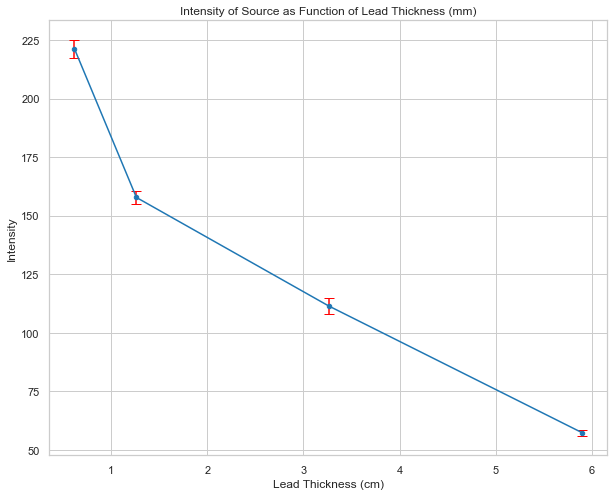

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

ax.errorbar(lead_1.index, lead_1['mean'], yerr=lead_1['y_err'], fmt='none', color='r', capsize=5, zorder=1)
ax.scatter(lead_1.index, lead_1['mean'], s=20, zorder=2)
ax.plot(lead_1.index, lead_1['mean'])
plt.title('Intensity of Source as Function of Lead Thickness (mm)')
plt.xlabel('Lead Thickness (cm)')
plt.ylabel('Intensity')
plt.show()

## Finding $\mu$, the Linear Attenuation Coefficient of L
We can directly compute it from this data.  The formula is:

$$I(x) = I_0 e^{-\mu x}$$
$$\mu = -\frac{1}{x}ln\left(\frac{I(x)}{I_0}\right)$$

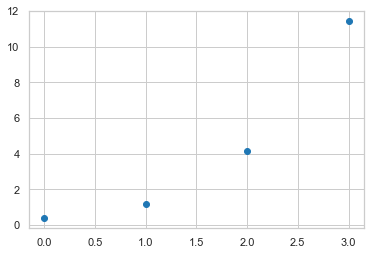

In [14]:
I_0 = 400.
zz = -1 * lead_1.index * np.log(lead_1.loc[:,'mean'] / I_0)
plt.scatter(np.arange(len(zz)), zz)

In [15]:
# Intensity of normal background + source
I_0 = lead_1['mean'][0]

att_lead_1 = -1 * lead_1.index * np.log(lead_1.loc[:,'mean'] / I_0)
att_lead_1 = att_lead_1[1:] # remove the infinity
att_lead_1 = att_lead_1 # 11.29
plt.plot(np.arange(len(att_lead_1)), att_lead_1)

KeyError: 0

In [16]:

u_lead = att_lead_1.mean()
u_lead_err = att_lead_1.std() / np.sqrt(len(att_lead_1)) * 3

print(f'u of lead: {u_lead:.3f} +/- {u_lead_err:.4f} g/cm^2' )

NameError: name 'att_lead_1' is not defined

$\mu = 0.088 \pm 0.0046 \frac{g}{mm^2}$

In [17]:
lead_1.loc[:, 'ln(I)'] = np.log(lead_1.loc[:, 'mean'])
lead_1

,mean,std,count,median,y_err,ln(I)
lead (cm),,,,,,
0.61725,221.238095,12.009264,42,221.5,3.706139,5.399239
1.26150,157.775862,7.823484,29,156.5,2.905569,5.061175
3.26150,111.460000,8.655345,25,111.0,3.462138,4.713666
5.89525,57.382353,6.470488,102,57.0,1.281347,4.049737


In [18]:
p_lead = 11.29
lead_1.loc[:, 'px'] = lead_1.index * p_lead
lead_1

,mean,std,count,median,y_err,ln(I),px
lead (cm),,,,,,,
0.61725,221.238095,12.009264,42,221.5,3.706139,5.399239,6.968752
1.26150,157.775862,7.823484,29,156.5,2.905569,5.061175,14.242335
3.26150,111.460000,8.655345,25,111.0,3.462138,4.713666,36.822335
5.89525,57.382353,6.470488,102,57.0,1.281347,4.049737,66.557372


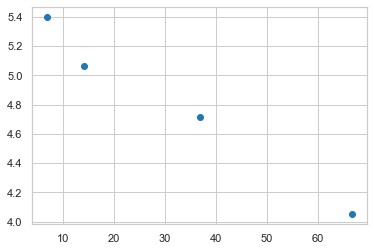

In [19]:

plt.scatter(lead_1['px'], lead_1['ln(I)'])

## Error Adjustment
Since I've put this in terms of $ln(I)$, I have to also adjust the errors.  For a logarithm it's just the error divided by the new value of ln(I).

In [20]:
lead_1.loc[:, 'y_err'] = lead_1['y_err'] / lead_1['ln(I)']
lead_1

,mean,std,count,median,y_err,ln(I),px
lead (cm),,,,,,,
0.61725,221.238095,12.009264,42,221.5,0.686419,5.399239,6.968752
1.26150,157.775862,7.823484,29,156.5,0.574090,5.061175,14.242335
3.26150,111.460000,8.655345,25,111.0,0.734490,4.713666,36.822335
5.89525,57.382353,6.470488,102,57.0,0.316403,4.049737,66.557372


In [21]:
from sklearn.linear_model import LinearRegression

x = lead_1['px'].to_numpy().reshape(-1,1)
y = lead_1['ln(I)'].to_numpy().reshape(-1,1)
y_err = lead_1['y_err'].to_numpy().reshape(-1,1)

model = LinearRegression().fit(x, y)
model.score(x, y)

0.982011640144057

In [22]:
print('Slope of fit: ',round(float(model.coef_), 4))

Slope of fit:  -0.0213


In [23]:
u_lead = -1 * float(model.coef_)
print(f' u of lead: {u_lead:.3f}')

 u of lead: 0.021


In [24]:
# Combining to calculate errors:
data = np.concatenate((x, y, y_err), axis=1)
data

array([[ 6.9687525 ,  5.39923948,  0.68641876],
       [14.242335  ,  5.06117543,  0.57408974],
       [36.822335  ,  4.71366578,  0.73448951],
       [66.5573725 ,  4.04973682,  0.31640266]])

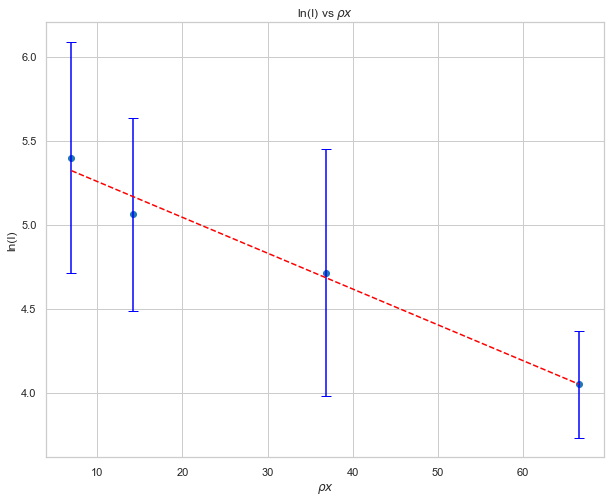

In [25]:
y_hat = model.predict(x)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y)
ax.plot(x, y_hat, linestyle='--', color='red')
ax.errorbar(data[:,0], 
            data[:,1], 
            yerr=data[:,2], fmt='none', color='b', capsize=5, zorder=1)
ax.set_title(r'ln(I) vs $\rho x$')
ax.set_xlabel(r'$\rho x$')
ax.set_ylabel('ln(I)')
plt.show()

So roughly 0.8 cm^-1 for $\mu$.

Calculating the 

In [26]:
N = lead_1.shape[0]
print(f'N: {N}')
delta = N*(x**2).sum() - (x.sum())**2
delta
sigma_u = np.sqrt(N / delta)
print(f'sigma u: {sigma_u:.3f}')

N: 4
sigma u: 0.022


In [27]:
print(f'Lead u range: [{u_lead - 2 * sigma_u}, {u_lead + 2*sigma_u}]')

Lead u range: [-0.021755407460243348, 0.06438151731862259]
